## Simple Image Classification problem

We're going to use a convolutional neural networks (CNN) to allow our computer to distinguish between 120 different dog breeds.

Many thanks to fast.ai (based on https://github.com/fastai/fastai/blob/master/courses/dl1/lesson1.ipynb)

## Classifying '120 Different Dog Breeds'

We will create a model to enter the [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification). There are 120 different dog breeds that are available for training. We will make a kaggle submission that will try to label the test set on Kaggle. 


In [3]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We will now import our needed libraries before we begin anything. 

In [4]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/home/jyi20/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [5]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` means the path directory to the data. 
`sz` means the size that the images will be resized to in order to make sure that the training process runs decently quick. We will leave it at `224`.

In [6]:
## resnet34 is a residual neural network that someone already trained with 34 layers. 
arch=resnet34
## make the path where you want it
PATH = "../data/dogbreed/"
sz=224

### Creating the initial data folder:

We first created the initial data folder within the cs152 folder. 
We then download the kaggle data into this folder. 

### Downloading the dataset from kaggle

In [7]:
#We will now download the dataset for dog breed identification from kaggle. 
#Uncomment the following api to download it:

#kaggle competitions download -c dog-breed-identification

However, in our situation we were not able to download the kaggle data. Therefore, we donwloaded the zip file directly from the kaggle website onto our machine. Then we uploaded the zip data file to jupyter directly. 

In [8]:
#Clean up the data folder first in the case we later have duplicates
!rm -rf /home/jyi20/cs152/data/dogbreed/train
!rm -rf /home/jyi20/cs152/data/dogbreed/valid
!rm -rf /home/jyi20/cs152/data/dogbreed/test

In [9]:
## Unzip all the .zip files in the following directory
!unzip -d /home/jyi20/cs152/data/dogbreed/ -qq /home/jyi20/cs152/data/dogbreed/\*.zip  


2 archives were successfully processed.


## A look at our test directory

The library assumes that we have the *train*, *valid*, and *test* directories. We will have to make a valid directory for all the subdirectories for the different dog breeds. 
The *test* directory will contain a set of test images whose filename starts with an ID.

In [13]:
os.listdir(PATH)

['train',
 'sample_submission.csv',
 'labels.csv',
 'result',
 'test.zip',
 'train.zip',
 'models',
 '.ipynb_checkpoints',
 'test']

In [14]:
files = os.listdir(f'{PATH}test')[:5]
files


['f1705303b30da3a48db2a5f34376b947.jpg',
 'a9b79809bc1301f8d148e15bfecf6485.jpg',
 'cc94a3bb7191a247f59e1540d8430c93.jpg',
 'f7b489a38302afc010d8a386a1b7d085.jpg',
 '6e21c96226078576342ca66e25eb1aa9.jpg']

## Our first model: quick start

We will now begin using the pre-trained model known as resnet34 which was created by someone else. We do not know the details of resnet34 to explain deeply. However, it will essentially help us solve our dog breed classification problem. 


In [15]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)
import shutil
import os

In [16]:
## import the needed pandas
import pandas
## read in the labels file
labels = pandas.read_csv(f'{PATH}labels.csv')
ids = labels['id']
breed = labels['breed']
train = f'{PATH}train/'
## make valid folder
valid = f'{PATH}valid/'
os.mkdir(f'{PATH}valid/')
## store the randomization sample in a variable
portion = random.sample(os.listdir(f'{PATH}train'),int(0.2*len(ids)))

## go through the number of ids, or the number of different types of dog breeds. 
for x in range(0,len(ids)):
    if f'{ids[x]}.jpg' in portion:
        ## if that breed folder does not exist, then make a new folder
        if os.path.exists(f'{valid}{breed[x]}') == False:
            os.mkdir(f'{valid}{breed[x]}')
        ## copy the images over
        shutil.copy(f'{train}{ids[x]}.jpg',f'{valid}{breed[x]}')
    else:
        if os.path.exists(f'{train}{breed[x]}') == False:
            os.mkdir(f'{train}{breed[x]}')
        shutil.copy(f'{train}{ids[x]}.jpg',f'{train}{breed[x]}')
    ## delete the old images after moving everything
    os.remove(f'{train}{ids[x]}.jpg')


In [17]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),
                                      test_name="test")

In [18]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.031, 2)

100%|██████████| 162/162 [00:56<00:00,  2.63it/s]


epoch      trn_loss   val_loss   accuracy   
    0      1.312554   0.620288   0.823875  
    1      0.73712    0.535485   0.834638  



[array([0.53548]), 0.8346379639584491]

## Creating predictions for test data and writing CSV


We see that by providing the *test_name* parameter to our dataset, we've now got a *test_ds* field in ou
model data.

In [19]:
data.test_ds.fnames[:10]

['test/f1705303b30da3a48db2a5f34376b947.jpg',
 'test/a9b79809bc1301f8d148e15bfecf6485.jpg',
 'test/cc94a3bb7191a247f59e1540d8430c93.jpg',
 'test/f7b489a38302afc010d8a386a1b7d085.jpg',
 'test/6e21c96226078576342ca66e25eb1aa9.jpg',
 'test/f16eed64196d24c423f0a68d7ebf287d.jpg',
 'test/635f438cd68b65dd6b4e100b338015fd.jpg',
 'test/b827855f566b9569fd668d990854ad0b.jpg',
 'test/5d1e83adfaac47f754f16021615fc8bf.jpg',
 'test/8a08c0b0d4554a270f66f2f16278ee70.jpg']

The next lines give predictions for the test data. We are also given log probabilities, meaning we have to exponentiate it in order to produce true probabilities.


In [20]:
log_preds, y = learn.predict_with_targs(is_test=True) # use test dataset rather than validation dataset
probs = np.exp(log_preds)

In [21]:
probs.shape # (n_images, n_classes)

(10357, 120)

Below are the 120 different types of dog breeds.


In [22]:
data.classes

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [23]:
probs[:,0:]

array([[0.     , 0.00001, 0.00008, ..., 0.00179, 0.00001, 0.00003],
       [0.00005, 0.     , 0.00012, ..., 0.     , 0.00004, 0.     ],
       [0.00007, 0.00015, 0.00007, ..., 0.00002, 0.00071, 0.00006],
       ...,
       [0.00023, 0.00003, 0.     , ..., 0.00097, 0.44418, 0.00015],
       [0.00007, 0.00001, 0.00012, ..., 0.00025, 0.00046, 0.00019],
       [0.00001, 0.     , 0.     , ..., 0.     , 0.     , 0.00009]], dtype=float32)

We create a Pandas DataFrame from breed probabilities. We name the column 'label'

In [24]:
df = pd.DataFrame(probs)
df.columns = data.classes

We want a new first column named *id* that has the ID extracted from each test image's filename.

In [25]:
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [26]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,f1705303b30da3a48db2a5f34376b947,8.744958e-07,0.000009,0.000075,0.001517,0.002115,0.000011,0.000002,0.000018,0.000003,...,0.000002,0.000005,0.080339,0.000115,0.782800,0.000022,0.000003,1.794033e-03,0.000009,0.000026
1,a9b79809bc1301f8d148e15bfecf6485,5.195799e-05,0.000002,0.000123,0.000003,0.000028,0.000092,0.000006,0.000007,0.000002,...,0.000009,0.000031,0.000003,0.000015,0.000011,0.000025,0.018792,8.749730e-07,0.000038,0.000004
2,cc94a3bb7191a247f59e1540d8430c93,7.317620e-05,0.000146,0.000066,0.000087,0.000007,0.020679,0.000009,0.000056,0.000181,...,0.000014,0.000043,0.000004,0.000268,0.000006,0.000280,0.000036,2.084621e-05,0.000708,0.000060
3,f7b489a38302afc010d8a386a1b7d085,6.388214e-06,0.000094,0.000003,0.000055,0.000018,0.137013,0.000003,0.000065,0.000190,...,0.000004,0.000008,0.000001,0.000241,0.000003,0.000105,0.000007,1.490577e-05,0.000051,0.000005
4,6e21c96226078576342ca66e25eb1aa9,1.214480e-02,0.006903,0.000180,0.005019,0.000094,0.000113,0.000588,0.000127,0.000361,...,0.000039,0.000009,0.000812,0.000168,0.000325,0.000374,0.000269,1.862413e-03,0.001260,0.001070


## Choosing a learning rate

We know choose a learning rate which determines how fast or slowly we want to update the weights. We would ideally want to choose a rate that is the most downward sloped and right before it becomes upward sloped. Otherwise, we would be overfitting. 

In [27]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [28]:
lrf=learn.lr_find()

 84%|████████▍ | 108/128 [00:01<00:00, 51.61it/s, loss=3.54]


Our `learn` object contains an attribute `sched` which produces a graph. 

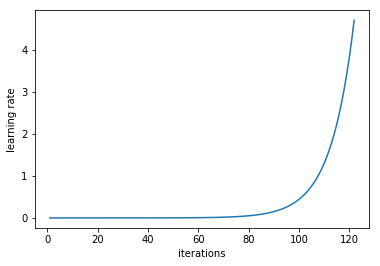

In [29]:
learn.sched.plot_lr()

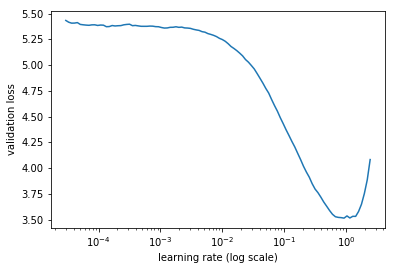

In [30]:
learn.sched.plot()

The loss is decreasing between 0.1 and 1. As a result, perhaps some value in between will be the appropriate learning rate. In our case, we chose 0.031 after trial and error and found that it was the best.

## Improving our model

### Data augmentation

Here, we will be augmenting the images so that they are rotated, moved slightly to the right, slanted, and so forth. This will help improve our model when classifying the dog breeds. 

In [31]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [32]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [33]:
ims = np.stack([get_augs() for i in range(6)])

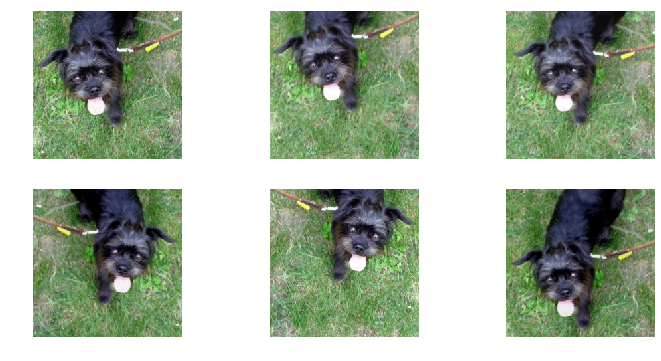

In [34]:
plots(ims, rows=2)

In [35]:
data = ImageClassifierData.from_paths(PATH, test_name="test", tfms=tfms)
learn = ConvLearner.pretrained(arch, data)

In [36]:
learn.fit(0.03, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      1.647698   0.88444    0.790607  
    1      0.982748   0.6058     0.832192  
    2      0.807464   0.545287   0.839041  



[array([0.54529]), 0.8390410957737678]

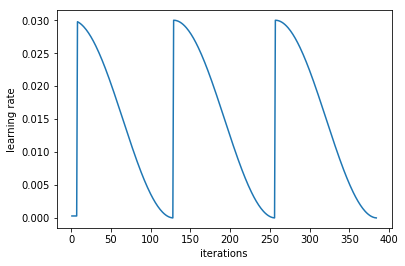

In [37]:
learn.sched.plot_lr()

In [38]:
learn.save('dogbreed_lastlayer')

In [39]:
learn.load('dogbreed_lastlayer')

We can look at the accuracy for 

In [40]:
log_preds, y = learn.predict_with_targs() # use test dataset rather than validation dataset
probs = np.exp(log_preds)
accuracy_np(probs, y)

0.839041095890411

In [41]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds), 0)
accuracy_np(probs, y)

0.8581213307240705

In [42]:
learn.save('dogbreed_augmentation')
learn.load('dogbreed_augmentation')

In [43]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds), 0)
df = pd.DataFrame(probs)
df.columns = data.classes
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])
SUBM = f'../../out/'
##f'../../cs152/data/dogbreed/result/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}dogbreedinteraction.gz', compression='gzip', index=False)



<img width="802" alt="dog breed identification kaggle submission" src="https://user-images.githubusercontent.com/39183226/46057489-a8c33800-c10a-11e8-87ef-af8a6e55157d.PNG">


We write into the *out* directory the dogbreedinteraction.zip CSV file. This gz file is the file we will be submitting.